# Модели

In [2]:
import numpy as np
import pytesseract
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from glob import glob

pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'

In [28]:
path = 'C:/Users/Anastasia/Documents/MY/PROJECTS/справки/deg_docs/test/*'
paths = sorted(glob(path))
img_path = paths[0]

In [49]:
def show(image, path=0, show=1):
    if path == 1:
        img = Image.open(image)
        img = np.array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        image = cv2.convertScaleAbs(image)
        img = Image.fromarray(image)
    
    string = pytesseract.image_to_string(img, lang='rus')
    print('len:', len(string))
    print(string)
    
    if show == 1:
        plt.figure(figsize=(15, 15))
        plt.imshow(img)
        plt.show()

len: 525
о 29, 2709

`Отьаткя зил кров (плазмы, «лоток «ров

Дата

т

Е

№. 27 ЗА
3

2

Коты

[2106 2019

кд (68)

пд (68].

129.08 2019

пл (68)

30092019

пуд (68)

25102020 | пд (а)

07112019

"пгуд (бе)

96112020 | пмд (68)

[02122018

"пли (65).

[20.01.2020]

пгуд (68)

5082021 | пуд (69)

2503:2021 | плд(б®) | 600
6%

ГГпмаея |

27.03.2020

плуд (68)

13.05.2020

‘плуд (68)

19.07 2021 | пуд (в)

25052021 | пд (68) | 600.

о

052020

‘оли 68) |

0.072020]

Г ппу (68)

19082021 [пд (68)
14102021 | пмд(6в)

д 69)

абныя 2




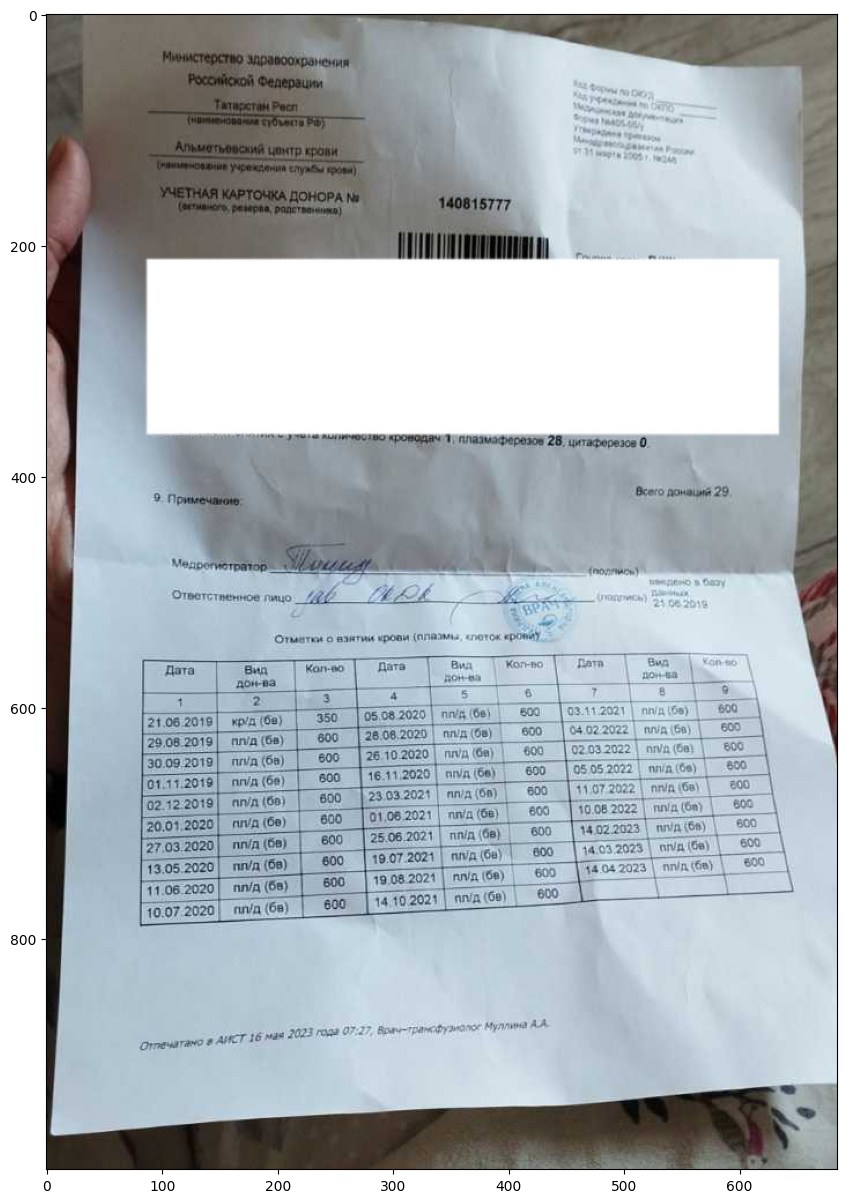

In [17]:
show(img_path, path=1)

## RRDN

In [25]:
import numpy as np


def process_array(image_array, expand=True):
    image_batch = image_array / 255.0
    if expand:
        image_batch = np.expand_dims(image_batch, axis=0)
    return image_batch


def process_output(output_tensor):
    sr_img = output_tensor.clip(0, 1) * 255
    sr_img = np.uint8(sr_img)
    return sr_img


def pad_patch(image_patch, padding_size, channel_last=True):
    if channel_last:
        return np.pad(
            image_patch,
            ((padding_size, padding_size), (padding_size, padding_size), (0, 0)),
            'edge',
        )
    else:
        return np.pad(
            image_patch,
            ((0, 0), (padding_size, padding_size), (padding_size, padding_size)),
            'edge',
        )


def unpad_patches(image_patches, padding_size):
    return image_patches[:, padding_size:-padding_size, padding_size:-padding_size, :]


def split_image_into_overlapping_patches(image_array, patch_size, padding_size=2):
    xmax, ymax, _ = image_array.shape
    x_remainder = xmax % patch_size
    y_remainder = ymax % patch_size
    
    # modulo here is to avoid extending of patch_size instead of 0
    x_extend = (patch_size - x_remainder) % patch_size
    y_extend = (patch_size - y_remainder) % patch_size
    
    # make sure the image is divisible into regular patches
    extended_image = np.pad(image_array, ((0, x_extend), (0, y_extend), (0, 0)), 'edge')
    
    # add padding around the image to simplify computations
    padded_image = pad_patch(extended_image, padding_size, channel_last=True)
    
    xmax, ymax, _ = padded_image.shape
    patches = []
    
    x_lefts = range(padding_size, xmax - padding_size, patch_size)
    y_tops = range(padding_size, ymax - padding_size, patch_size)
    
    for x in x_lefts:
        for y in y_tops:
            x_left = x - padding_size
            y_top = y - padding_size
            x_right = x + patch_size + padding_size
            y_bottom = y + patch_size + padding_size
            patch = padded_image[x_left:x_right, y_top:y_bottom, :]
            patches.append(patch)
    
    return np.array(patches), padded_image.shape


def stich_together(patches, padded_image_shape, target_shape, padding_size=4):
    xmax, ymax, _ = padded_image_shape
    patches = unpad_patches(patches, padding_size)
    patch_size = patches.shape[1]
    n_patches_per_row = ymax // patch_size
    
    complete_image = np.zeros((xmax, ymax, 3))
    
    row = -1
    col = 0
    for i in range(len(patches)):
        if i % n_patches_per_row == 0:
            row += 1
            col = 0
        complete_image[
        row * patch_size: (row + 1) * patch_size, col * patch_size: (col + 1) * patch_size, :
        ] = patches[i]
        col += 1
    return complete_image[0: target_shape[0], 0: target_shape[1], :]

In [21]:
import numpy as np


class ImageModel:
    def predict(self, input_image_array, by_patch_of_size=None, batch_size=10, padding_size=2):
        if by_patch_of_size:
            lr_img = process_array(input_image_array, expand=False)
            patches, p_shape = split_image_into_overlapping_patches(
                lr_img, patch_size=by_patch_of_size, padding_size=padding_size
            )
            # return patches
            for i in range(0, len(patches), batch_size):
                batch = self.model.predict(patches[i: i + batch_size])
                if i == 0:
                    collect = batch
                else:
                    collect = np.append(collect, batch, axis=0)
            
            scale = self.scale
            padded_size_scaled = tuple(np.multiply(p_shape[0:2], scale)) + (3,)
            scaled_image_shape = tuple(np.multiply(input_image_array.shape[0:2], scale)) + (3,)
            sr_img = stich_together(
                collect,
                padded_image_shape=padded_size_scaled,
                target_shape=scaled_image_shape,
                padding_size=padding_size * scale,
            )
        
        else:
            lr_img = process_array(input_image_array)
            sr_img = self.model.predict(lr_img)[0]
        
        sr_img = process_output(sr_img)
        return sr_img

In [23]:
import tensorflow as tf
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import concatenate, Input, Activation, Add, Conv2D, Lambda
from tensorflow.keras.models import Model

WEIGHTS_URLS = {
    'gans': {
        'arch_params': {'C': 4, 'D': 3, 'G': 32, 'G0': 32, 'x': 4, 'T': 10},
        'url': 'https://public-asai-dl-models.s3.eu-central-1.amazonaws.com/ISR/rrdn-C4-D3-G32-G032-T10-x4-GANS/rrdn-C4-D3-G32-G032-T10-x4_epoch299.hdf5',
        'name': 'rrdn-C4-D3-G32-G032-T10-x4_epoch299.hdf5',
    },
}


def make_model(arch_params, patch_size):
    return RRDN(arch_params, patch_size)


def get_network(weights):
    if weights in WEIGHTS_URLS.keys():
        arch_params = WEIGHTS_URLS[weights]['arch_params']
        url = WEIGHTS_URLS[weights]['url']
        name = WEIGHTS_URLS[weights]['name']
    else:
        raise ValueError('Available RRDN network weights: {}'.format(list(WEIGHTS_URLS.keys())))
    c_dim = 3
    kernel_size = 3
    return arch_params, c_dim, kernel_size, url, name


class RRDN(ImageModel):
    def __init__(
            self, arch_params={}, patch_size=None, beta=0.2, c_dim=3, kernel_size=3, init_val=0.05, weights=''
    ):
        if weights:
            arch_params, c_dim, kernel_size, url, fname = get_network(weights)
        
        self.params = arch_params
        self.beta = beta
        self.c_dim = c_dim
        self.C = self.params['C']
        self.D = self.params['D']
        self.G = self.params['G']
        self.G0 = self.params['G0']
        self.T = self.params['T']
        self.scale = self.params['x']
        self.initializer = RandomUniform(minval=-init_val, maxval=init_val, seed=None)
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.model = self._build_rdn()
        self.model._name = 'generator'
        self.name = 'rrdn'
        if weights:
            weights_path = tf.keras.utils.get_file(fname=fname, origin=url)
            self.model.load_weights(weights_path)
    
    def _dense_block(self, input_layer, d, t):
        x = input_layer
        for c in range(1, self.C + 1):
            F_dc = Conv2D(
                self.G,
                kernel_size=self.kernel_size,
                padding='same',
                kernel_initializer=self.initializer,
                name='F_%d_%d_%d' % (t, d, c),
            )(x)
            F_dc = Activation('relu', name='F_%d_%d_%d_Relu' % (t, d, c))(F_dc)
            x = concatenate([x, F_dc], axis=3, name='RDB_Concat_%d_%d_%d' % (t, d, c))
        
        x = Conv2D(
            self.G0,
            kernel_size=3,
            padding='same',
            kernel_initializer=self.initializer,
            name='LFF_%d_%d' % (t, d),
        )(x)
        return x
    
    def _RRDB(self, input_layer, t):
        x = input_layer
        for d in range(1, self.D + 1):
            LFF = self._dense_block(x, d, t)
            LFF_beta = MultiplyBeta(self.beta)(LFF)
            x = Add(name='LRL_%d_%d' % (t, d))([x, LFF_beta])
        x = MultiplyBeta(self.beta)(x)
        x = Add(name='RRDB_%d_out' % (t))([input_layer, x])
        return x
    
    def _pixel_shuffle(self, input_layer):
        x = Conv2D(
            self.c_dim * self.scale ** 2,
            kernel_size=3,
            padding='same',
            kernel_initializer=self.initializer,
            name='PreShuffle',
        )(input_layer)

        return PixelShuffle(self.scale)(x)
    
    def _build_rdn(self):
        LR_input = Input(shape=(self.patch_size, self.patch_size, 3), name='LR_input')
        pre_blocks = Conv2D(
            self.G0,
            kernel_size=self.kernel_size,
            padding='same',
            kernel_initializer=self.initializer,
            name='Pre_blocks_conv',
        )(LR_input)
        for t in range(1, self.T + 1):
            if t == 1:
                x = self._RRDB(pre_blocks, t)
            else:
                x = self._RRDB(x, t)
        post_blocks = Conv2D(
            self.G0,
            kernel_size=3,
            padding='same',
            kernel_initializer=self.initializer,
            name='post_blocks_conv',
        )(x)
        GRL = Add(name='GRL')([post_blocks, pre_blocks])
        PS = self._pixel_shuffle(GRL)
        SR = Conv2D(
            self.c_dim,
            kernel_size=self.kernel_size,
            padding='same',
            kernel_initializer=self.initializer,
            name='SR',
        )(PS)
        return Model(inputs=LR_input, outputs=SR)

class PixelShuffle(tf.keras.layers.Layer):
    def __init__(self, scale, *args, **kwargs):
        super(PixelShuffle, self).__init__(*args, **kwargs)
        self.scale = scale

    def call(self, x):
        return tf.nn.depth_to_space(x, block_size=self.scale, data_format='NHWC')

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'scale': self.scale,
        })
        return config

class MultiplyBeta(tf.keras.layers.Layer):
    def __init__(self, beta, *args, **kwargs):
        super(MultiplyBeta, self).__init__(*args, **kwargs)
        self.beta = beta

    def call(self, x, **kwargs):
        return x * self.beta

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'beta': self.beta,
        })
        return config

In [30]:
img = Image.open(img_path)
lr_img = np.array(img)
lr_img = tf.expand_dims(lr_img, axis=-1)
lr_img = tf.cast(lr_img, tf.float32)

1/1 [==============================] - 53s 53s/step
len: 513
ОО О 282
1 ых

Медве

`Стветственное лицо: 2267

->

'ОтАлатки д `ззнтии крови (ппзмы, «поток ировиу,,

Пати. | | каж |
вон-ва ||

Вид
Дона

|
|

—_— Ад (Фа) | г [03112021 паче | 1 6
в г. (08) | 1 63.02-2022 |'плёди68у | 605
о :02:2022 | плед 168) |_ 9%

[02032027 | пила (бе | 896 |
[105952022 | вла (68) || 806
410726221 олуд (68) \ 2006 |
ооо пд 88) | 606

145 под 58) | 8

плуд (ба) |
пуд (58) |

+

ила 68) |

| мула) |

НЕТ а 47.97 |. НриаАе мулине А.А
ег ЕЯ ЗО2з под 07:27, Врач прану

бзечатана а №

в \




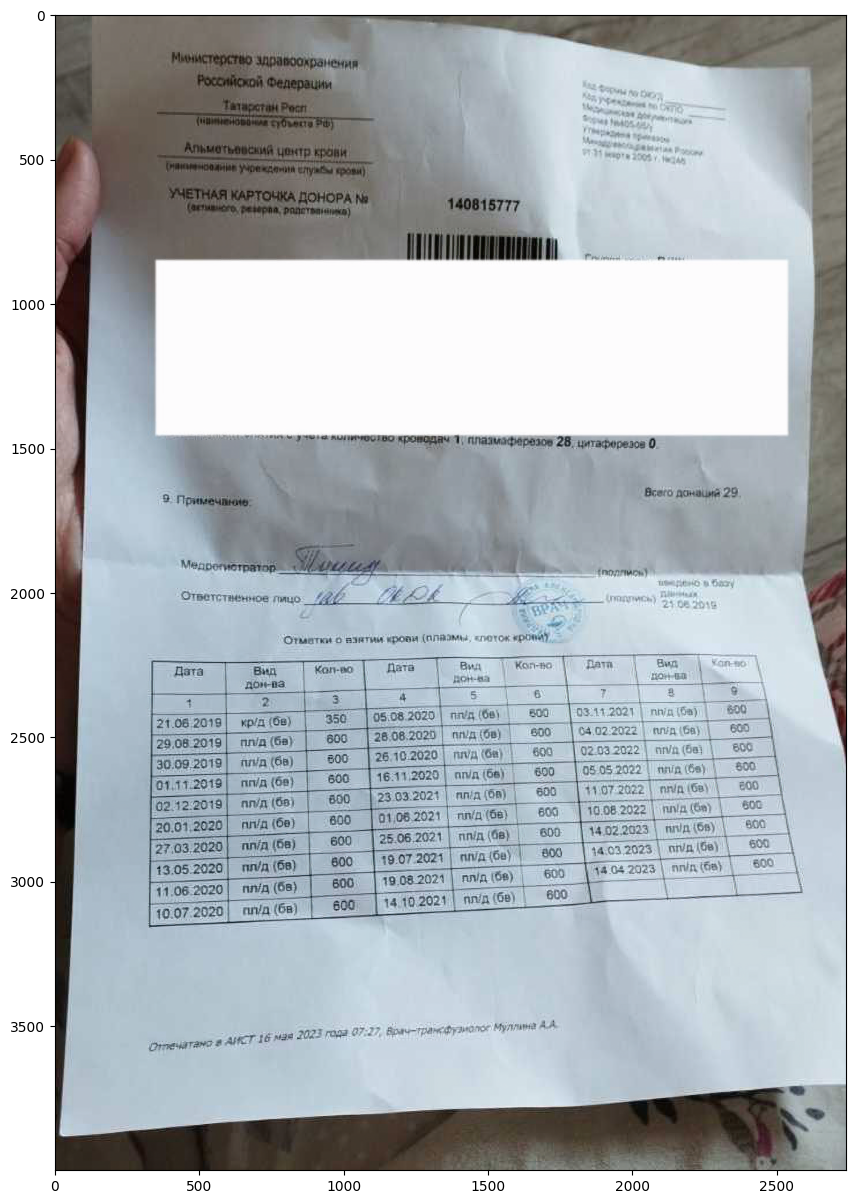

In [35]:
model = RRDN(weights='gans')
sr_img = model.predict(lr_img)
show(sr_img)

## MIRNet

In [52]:
image = Image.open(img_path)
width, height = image.size

new_width = int(height * (748 / 1000))

resized_image = image.resize((new_width, height))

image_array = np.array(resized_image)

reshaped_image_array = np.expand_dims(image_array, axis=0)

In [53]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("keras-io/lowlight-enhance-mirnet")


config.json not found in HuggingFace Hub.


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

In [54]:
pred = model.predict(reshaped_image_array)

1/1 [==============================] - 68s 68s/step


len: 0



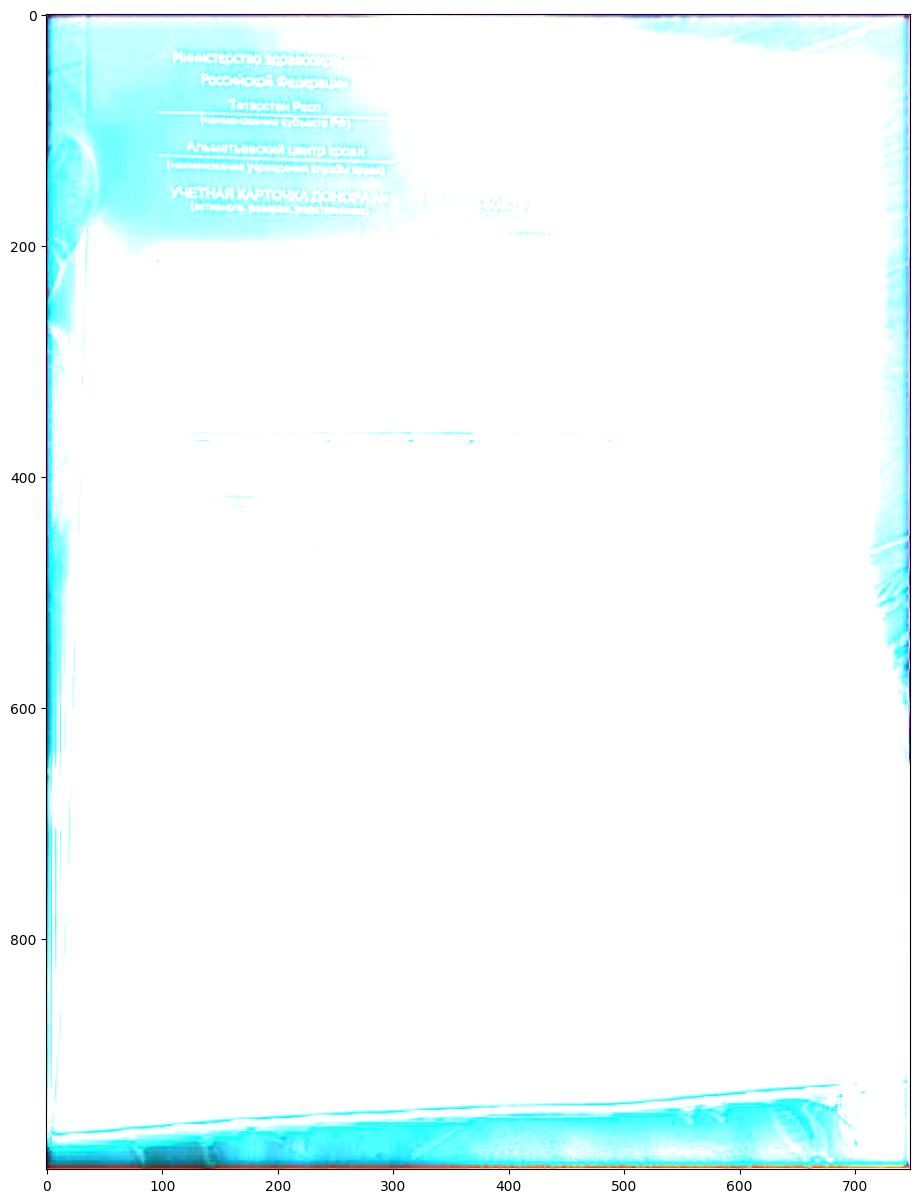

In [55]:
prediction_image_array = np.squeeze(pred, axis=0)

show(prediction_image_array)

## H-DIBCO 2018

len: 57
ь

ны: т. ета зуено

© пени,

=
ие Ими
еее Я И ”..

с“ \



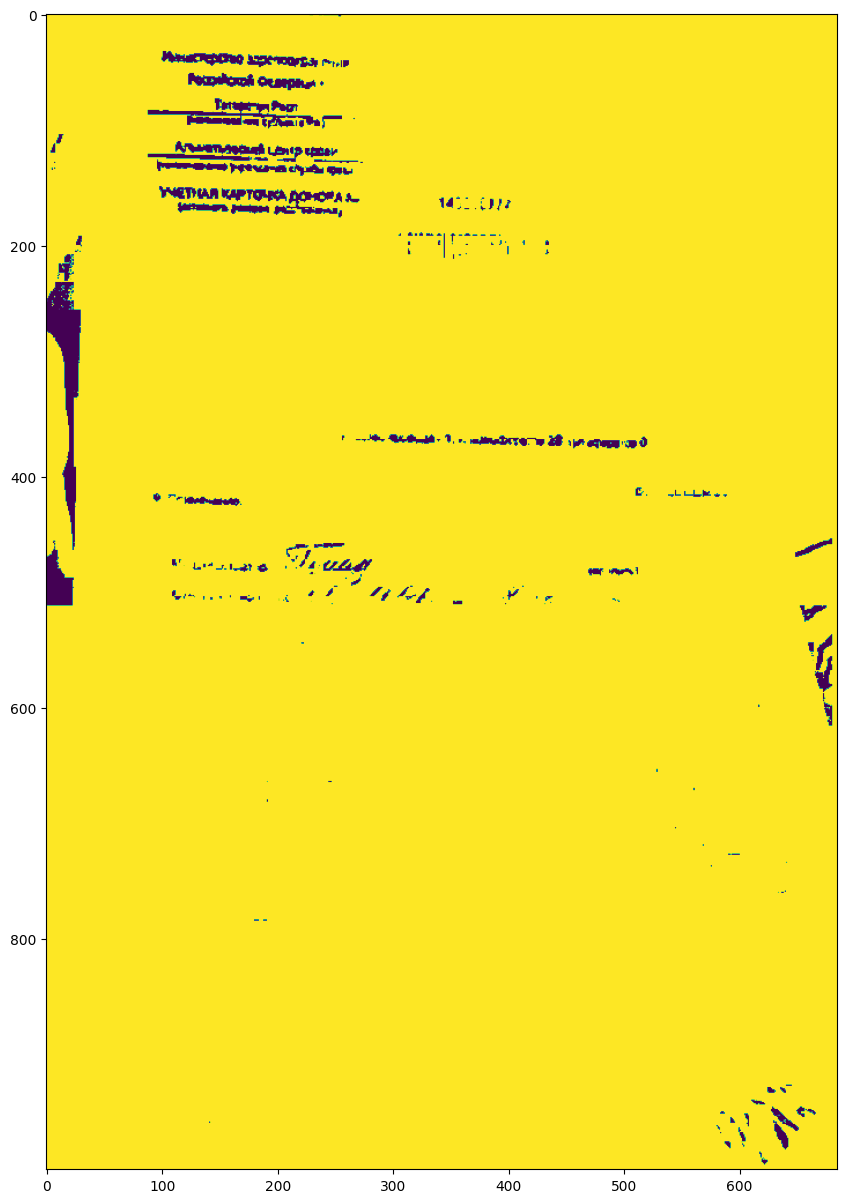

In [58]:
show(path + 'output.png', path=1)

## RealESRGAN

In [6]:
import subprocess

In [42]:
path = 'C:/Users/Anastasia/Downloads/'
model_path = path + 'RealESRGAN_x4plus.pth'
script_path = path + 'inference_realesrgan.py'

In [9]:
command1 = f'python inference_realesrgan.py --model_path RealESRGAN_x4plus.pth --input {img_path} '
command2 = f'--output {path} --fp32'
full_command = command1 + command2
subprocess.run(full_command, shell=True)

CompletedProcess(args='python inference_realesrgan.py --model_path RealESRGAN_x4plus.pth --input C:/Users/Anastasia/Documents/MY/PROJECTS/справки/deg_docs/test\\204119 .jpg --output C:/Users/Anastasia/Downloads/ --fp32', returncode=2)

len: 777
Яр
СВ у
; ра Или м) 09107

УЛ) в
№ РАО 81 0570
пе Ч оллуро
рули
Эла 1166,.1/0/ ыы

И,

ОА Олл

\ иПоОль
ООО оли ы
91 рот и

"ПЛ гл Рой
® Роу биь
200% ЗАЛ

Галляла гаи,

Нч 1, пляамоФорооов 28. цигафорегов 0.

Эсого докошия 29.

Тоойимот) у 1
000)(0 в Обэу

о Прил

°’ 24. 0020\8

(Лоплмю
си

>. ия

Отмотки о взятии крови (О@лвомы, дооток ирое (у 2

Дата Вид Кол-во
дои-ва

Кол-во
У : (06) хх 08.41.2021 | ппуд (бе)
пл/д (06 в.
|21.06 2018 | `06 2019| крид (бе) .
29.06.2019 | пл/д (6е) Г 600 26.08.2020 в09 [04022022 | пмд6ь) | 600 \

Вил Хоп:®О
ро ва

8

а 92.03.2022 | пла бо | 60 |
ам =. 05 052022 | пл/д (66) | 2% |
Г в00 [23502.2021 | пла (68) еб | 11072022 а
а а | по 69

: 021
10.07.

я ы — эмовос Муллиио АЛ
2022 года 07:27, Вояч-трамефузи
в АИСТ 16 ман

Отпаия 76°)




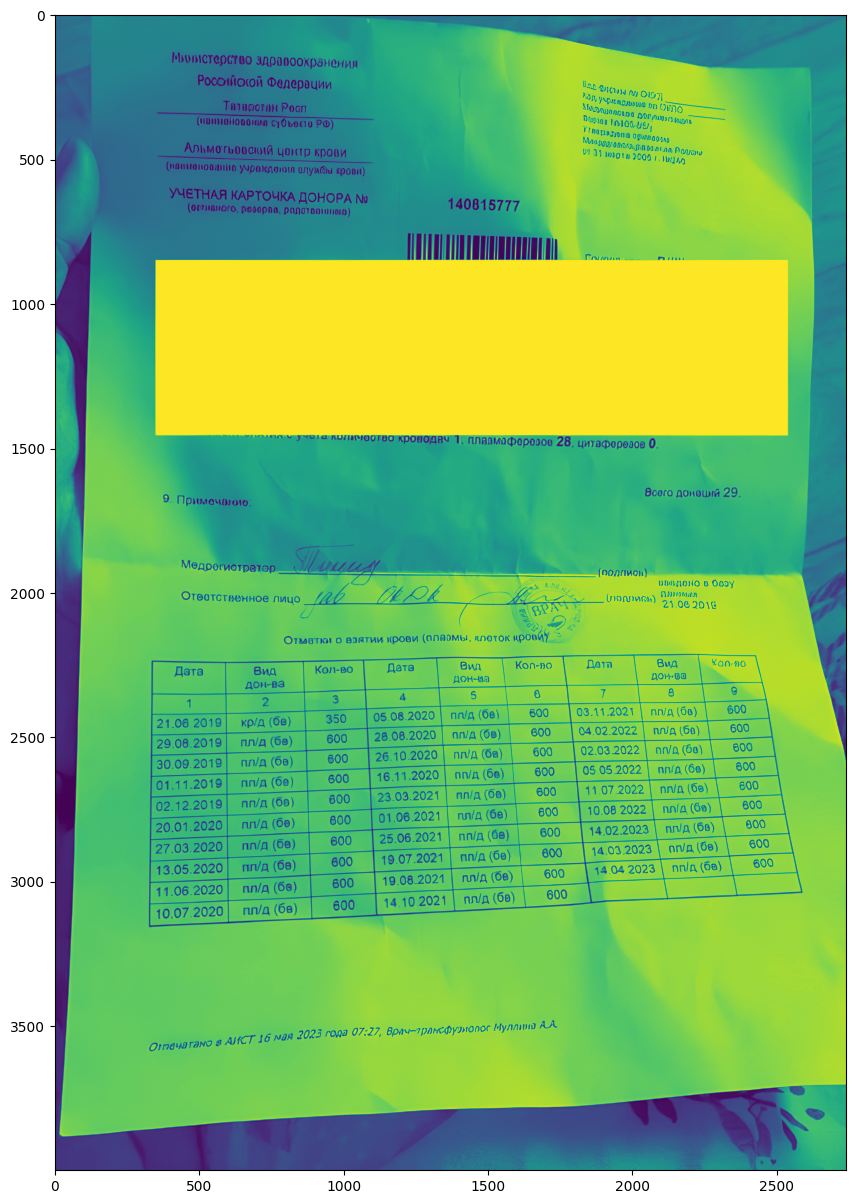

In [56]:
show(path + '141899_out.jpg', path=1)

<div style="border:solid steelblue 5px; padding: 30px">
<p>
        <b>Берём RealESRGAN как единственную модель предобработки.</b>
    </p>  
</div>